In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from typing import Optional
from collections import deque
from timeit import default_timer as timer
from typing import Optional, NewType, Union

$\textbf{Exercise 1: Spike-triggered average}$

In [2]:
matData = loadmat("c1p8.mat")
rho, stim = matData['rho'].flatten(), matData['stim'].flatten()

#Global variables:

TIME_RANGE = np.arange(0,300,2)
FIRING_RATE = rho.mean()

In [3]:
def STA(rho=rho, stim=stim, trial_times=TIME_RANGE):
    
    spikes = rho
    
    num_spikes = rho.sum()
    
    result = np.zeros(trial_times.shape)
    
    for timeI, time in np.ndenumerate(trial_times):
        
        result[timeI] = np.sum(np.where(spikes==1, stim, 0))
        spikes = np.roll(spikes,shift=-1)
        spikes[-1] = 0
        
    return result / num_spikes

In [4]:
start = timer()
sta = STA()
end = timer()

print("Execution time for looping method: {}".format(end-start))

start = timer()
sta2 = np.correlate(rho, stim, mode="same") / np.sum(rho)
end = timer()

print("Execution time for correlation: {}".format(end-start))

Execution time for looping method: 0.4854504649999998
Execution time for correlation: 97.922650013


As predicted, the looping method is much faster than the correlation method. This is because the looping method only has to go through 150 iterations, whereas the correlation goes over the entire time range.

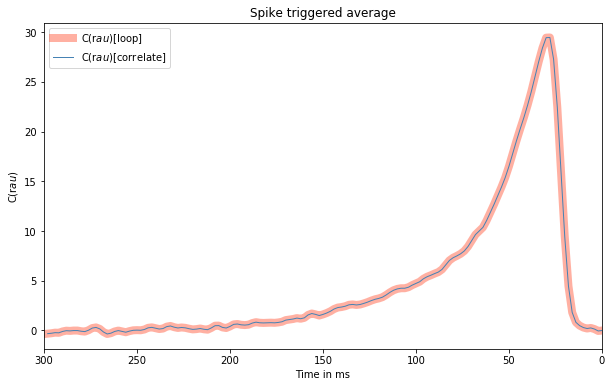

In [5]:
def plot_STA ():

    plt.figure(figsize = (10,6))
    
    plt.xlim(300, 0) #time backwards
    plt.title("Spike triggered average")
    plt.plot(np.arange(0,300,2),sta, c = 'tomato',\
             linewidth = 8, alpha=.5, label = "C(r$\tau$)[loop]") 
    plt.plot(np.arange(0,300,2), sta2[300000:300150], c = 'steelblue',\
             linewidth=1, label = "C(r$\tau$)[correlate]") #take the relevant 300 seconds
    plt.xlabel("Time in ms")
    plt.ylabel("C(r$\tau$)")
    plt.legend()
    
    plt.show()
    
plot_STA()

Indeed we see that the structure of these is perfectly overleaid. In any case, the stike-triggered average stimulus peaks sharply just before the onset of the spike.

$\textbf{Exercise 2: Linear Encoding kernel $D$}$

In [6]:
sigma, r = stim.var()*2, rho.mean() * 500 #firing rate = spikes/second

D = np.zeros(stim.shape)

for t in range(sta.shape[0]):
    D[t] = r*sta[t]/sigma

$\textbf{Part 3: Predicting a neuron's response}$

In [7]:
#Estimate the firing rate using kernel
def r_est (filt, stim, frate=FIRING_RATE):
    
    response = np.convolve(D, stim, mode="same")

    r_0 = frate - response.mean()
    
    return r_0 + response

In [8]:
rEstim = r_est(D,stim)

In [9]:
rec_window_func = lambda tau, dt: 1/dt if -dt/2 <= tau < dt/2 else 0

def convolution(window, spikes, wp: Optional):
    
    """
    Returns the convolution of window with spike times
    @params:
    window: the kind of window to be used
    wp: a window paramater that can be used to scale e.g.
    the width of the window 
    """
    
    w = np.array([window(time, wp) for time in TIME_RANGE])
    
    return np.convolve(spikes,w , 'same')

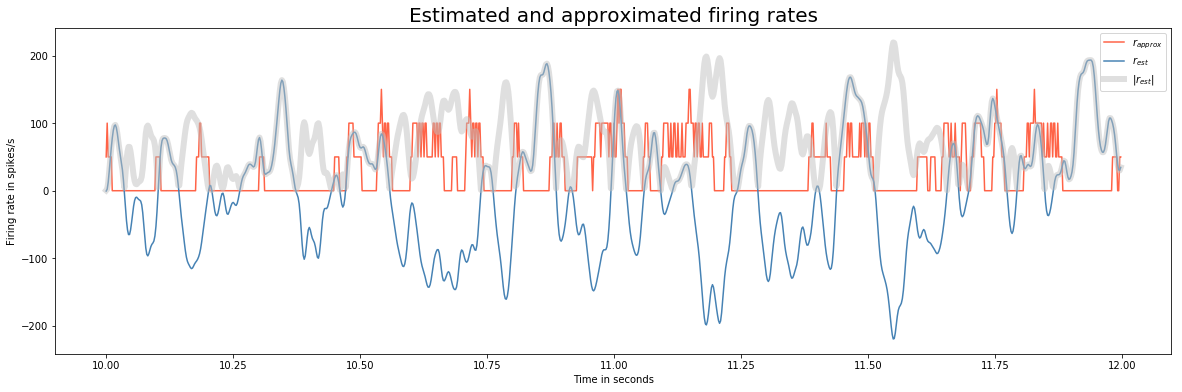

In [10]:
start = timer()
r_approx = convolution(rec_window_func, rho, 20)
end = timer()

r_approx.shape
plt.figure(figsize=(20,6))
plt.title("Estimated and approximated firing rates", fontsize =20)
plt.plot(np.arange(10,12,.002), r_approx[5000:6000]*1000, color = 'tomato',\
         label = r"$r_{approx}$")
plt.xlabel("Time in seconds")
plt.ylabel("Firing rate in spikes/s")
plt.plot(np.arange(10,12,.002),rEstim[5000:6000], color = 'steelblue', label= r"$r_{est}$")
plt.plot(np.arange(10,12,.002),np.abs(rEstim[5000:6000]), color = 'silver', alpha=.5,\
         linewidth=6, label= r"|$r_{est}|$")
plt.legend()

There appears to be very little similarity between these two curves (if there is, I cannot find it). This is at least a little bit surprising to me. After all, both curves embody estimates of the neuron's firing rate. I thought it would be useful to plot the absolute value as well, but even here there is very little similarity

$\textbf{Extra: Real spike trains versus Poisson process}$

Text(0.5, 0, 'Time in seconds')

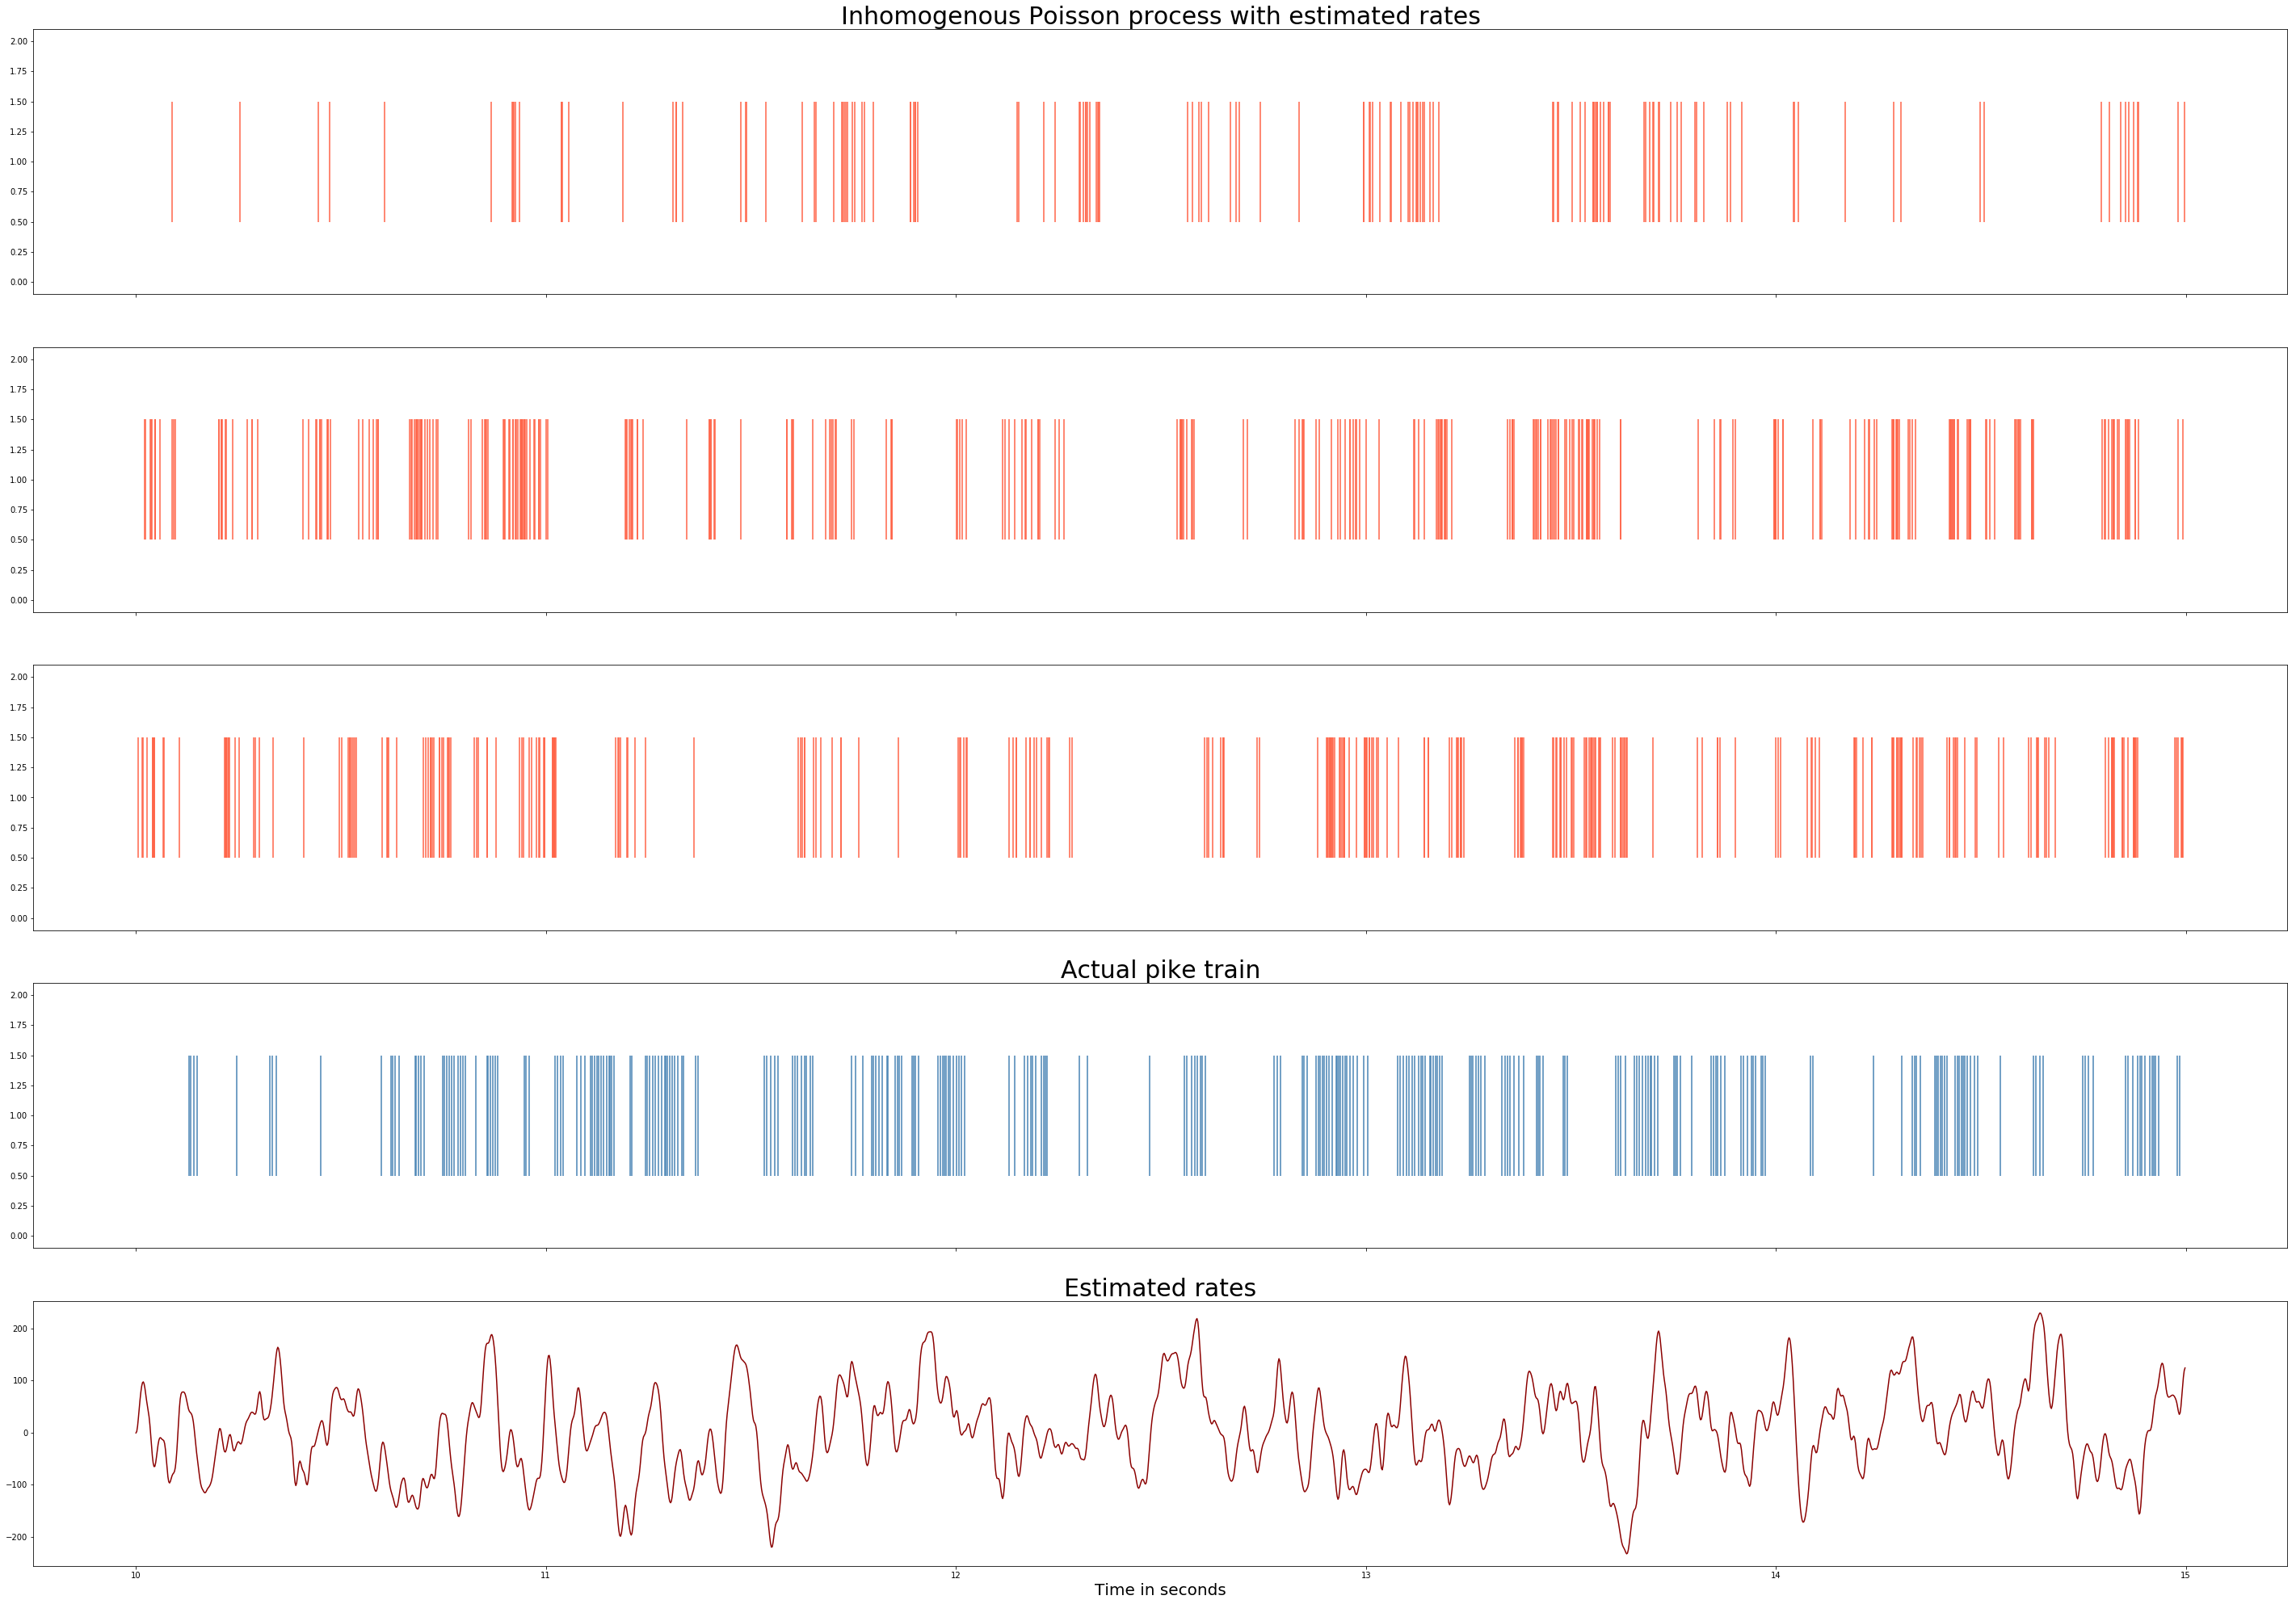

In [11]:
#Part(a): 

def hom_poisson(n, rate):
    '''
    Generates events from a homogenous Poisson process:
    @params:
    n: the number of events to be generated
    rate: the rate that determines event intervals
    '''
    
    randNumbers = np.random.rand(n)
    ISIs = -np.log(randNumbers)/rate
    ISIs2 = ISIs*500 #to ms
    
    return np.cumsum(ISIs2)

def inhom_poisson(n, rates):
    
    '''
    Generates and inhomogenous Poisson process from
    a homogenous one using event-thinning
    @params:
    n: the number of events ro be generated
    rates: an array of rates
    '''
    
    #Probabilities for generating a spike:
    rts = rates/rates.max()
    hom = hom_poisson(n, rates.max())
    
    #Generate random numbers for thinning:
    randNums = np.random.rand(n)
    
    #Thinning: 
    hom2 = hom[randNums < rts]
    
    return hom2


tRange = np.arange(10,15,.001)
res1 = inhom_poisson(600000, rEstim)/500 #to seconds

#Filter the correct time interval:
res1 = res1[res1 < 15]
res1 = res1[10 <= res1]

fig, axs = plt.subplots(5,1, figsize=(50,35), sharex=True)

axs[0].eventplot(res1,color = 'tomato')
axs[0].xticks = (np.arange(5,7.5,.001))
axs[0].set_title("Inhomogenous Poisson process with estimated rates", fontsize=30)
resFromRho = 10 + np.where(rho[5000:7500]==1)[0]*.002

#res = inhom_poisson(600000, rEstim)/1000 #to seconds

res2 = inhom_poisson(600000, rEstim)/1000 #to seconds
res2 = res2[res2 < 15]
res2 = res2[10 <= res2]

axs[1].eventplot(res2,color = 'tomato')
axs[1].xticks = (np.arange(5,7.5,.001))
resFromRho = 10 + np.where(rho[5000:7500]==1)[0]*.002

res3 = inhom_poisson(600000, rEstim)/1000 #to seconds
res3 = res3[res3 < 15]
res3 = res3[10 <= res3]

axs[2].eventplot(res3,color = 'tomato')
axs[2].xticks = (np.arange(5,7.5,.001))
resFromRho = 10 + np.where(rho[5000:7500]==1)[0]*.002


axs[3].eventplot(resFromRho, color= "steelblue")
axs[3].set_title("Actual pike train", fontsize=30)
axs[4].plot(np.arange(10,15,.002),rEstim[5000:7500], color = 'darkred')
axs[4].set_title("Estimated rates",fontsize=30)
axs[4].set_xlabel("Time in seconds",fontsize=20)

Again, I'm a little skeptical about this result. There is very little resemblance between the synthetic and the actual spike train. To some extend this is expected, since the synthetic spike train is generated using probabilistic thining. For this reason I computed three diffent synthetic trains to look for regularities (this would be useful, for example, when a lot of the normalised rates are close to .5, so the signal contains a lot of noise – in this case we would see very few regularities over different runs of the thinning procedure). The result is so-so. We do in fact see some regularity, but there is also a lot of variation. None of the spike trains, however, seems to resemble the actual spike train better than any of the others. However, some of the higher-level properties of the spike train appear to be preserved. For instance, like the original neuron, all the synthetic neurons appear to fire in short bursts.

I also thought a little bit about how the standard procedure for generating spike trains from an inhomogenous Poisson process (using the thinning method) interfaces with the negative values such as those we encounter in $r_{estim}$. When you follow the procedure given in the generatePoisson.py file, you get an overall firing rate that is very much higher than that of the actual spike train. This, in part, is because whatever random number you generate in the intervals where $r_{estim}$ is negative, you will keep the corresponding spike. I thought about generating random numbers from a $\mathfrak{U}_{[-1,1]}$ instead of $\mathfrak{U}_{[0,1]}$, but settled for the above method instead. It seems correct to keep all spikes with random numbers that are smaller, than the respective rates, since the rates are normalised and hence represent probabilities of keeping the spike. You want spikes with larger probabilities to stay and spikes with smaller probabilities to go. Hence I turned the comparision (> to <) compared to the original method. Again, I am not sure whether that was correct and would appreciate some insight.